In [317]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from itertools import product

tab10 = mpl.colormaps["tab10"]

In [318]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

(11, 15)

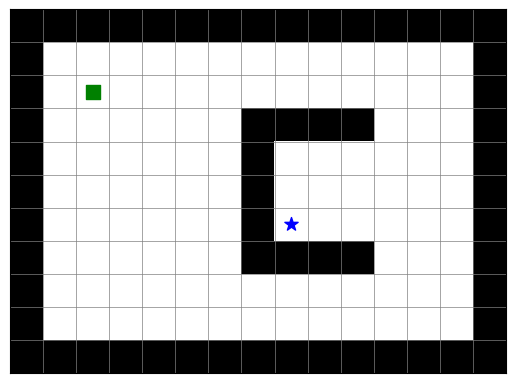

In [319]:
maze = np.zeros((9, 13))


# place walls
maze[2, 6:10] = 1
maze[-3, 6:10] = 1
maze[2:-3, 6] = 1

# define start
start = (6, 8)

pad = np.ones(np.array(maze.shape) + 2)
pad[1:-1, 1:-1] = maze
maze = pad


# define goal (we abuse function scoping a bit here, later we will change the goal, which will automatically change the goal in our actor critic as well)
goal = (2, 2)
goal_state = goal[0]*maze.shape[1] + goal[1]
goal_value = 10

def plot_maze(maze, start=None, end=None, ax=None):
    plot_ground = plt
    if ax is not None:
        plot_ground = ax
    plot_ground.imshow(maze, cmap='binary')

    # draw thin grid
    for i in range(maze.shape[0]):
        plot_ground.plot([-0.5, maze.shape[1]-0.5], [i-0.5, i-0.5], c='gray', lw=0.5)
    for i in range(maze.shape[1]):
        plot_ground.plot([i-0.5, i-0.5], [-0.5, maze.shape[0]-0.5], c='gray', lw=0.5)
    if start is not None:
        plot_ground.scatter(start[1],start[0],marker='*',color='blue',s=100)
    if end is not None:
       plot_ground.scatter(end[1],end[0],marker='s',color='green',s=100)
    
    if ax is not None:
        plot_ground.set_xticks([])
        plot_ground.set_yticks([])
    else:
        plot_ground.xticks([])
        plot_ground.yticks([])

def plot_path(maze, path, ax=None):
    # plot a maze and a path in it
    plot_maze(maze, ax=ax)
    path = np.array(path)
    
    plot_ground = plt
    if ax is not None:
        plot_ground = ax
    plot_ground.plot(path[:, 1], path[:, 0], c = 'red', lw = 3)
    plot_ground.scatter(path[0, 1], path[0, 0], marker = '*', color = 'blue', s = 100)
    plot_ground.scatter(path[-1, 1], path[-1, 0], marker = '*', color = 'green', s = 100)
    

plot_maze(maze, start, goal)
maze.shape

In [320]:
def compute_transition_matrix(maze):
    # for a given maze, compute the transition matrix from any state to any other state under a random walk policy
    # (you will need to think of a good way to map any 2D grid coordinates onto a single number for this)

    # create a matrix over all state pairs
    transitions = np.zeros((maze.size, maze.size))

    # iterate over all states, filling in the transition probabilities to all other states on the next step (only one step into the future)
    for i in range(maze.shape[0]):
        for j in range(maze.shape[1]):
            # check if state is valid
            if maze[i, j] == 0:
                # iterate over all possible moves
                for move in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
                    new_i, new_j = i + move[0], j + move[1]
                    # check if new state is valid
                    if new_i >= 0 and new_i < maze.shape[0] and new_j >= 0 and new_j < maze.shape[1] and maze[new_i, new_j] == 0:
                        transitions[i*maze.shape[1] + j, new_i*maze.shape[1] + new_j] = 1
    
    # normalize transitions
    transitions /= transitions.sum(axis=1, keepdims=True)

    # remove NaNs
    transitions[np.isnan(transitions)] = 0

    return transitions

transitions = compute_transition_matrix(maze)

/tmp/ipykernel_5023/2572442783.py:21: RuntimeWarning: invalid value encountered in divide
  transitions /= transitions.sum(axis=1, keepdims=True)


In [321]:
def analytical_sr(transitions: np.ndarray, gamma: float) -> np.ndarray:
    """do the closed form solution for successor representation. Equal to the infinite product. 

    Args:
        transitions (np.ndarray): transition matrix from state to state
        gamma (float): discount factor

    Returns:
        np.ndarray: updated transition matrix
    """
    return np.linalg.inv(np.eye(transitions.shape[0]) - gamma * transitions.T)

i, j = start
# compute the SR for all states, based on the transition matrix
# note that we use a lower discounting here, to keep the SR more local
analytical_state_repr = analytical_sr(transitions, 0.6)

In [322]:
# One part to the solution of exercise part 3, if you want to update the SR after each episode
def learn_from_traj(succ_repr, trajectory, gamma=0.98, alpha=0.05):
    # Write a function to update a given successor representation (for the state at which the trajectory starts) using an example trajectory
    # using discount factor gamma and learning rate alpha

    observed = np.zeros_like(succ_repr)

    for i, state in enumerate(trajectory):
        observed[state] += gamma ** i

    succ_repr += alpha * (observed - succ_repr)

    # return the updated successor representation
    return succ_repr

# Part 1:

program an actor critic algorithm to navigate the maze, using a table of action propensities M with softmax action selection as actor, and a learned state-value function as critic


In [323]:
from tqdm import tqdm


def softmax(x: np.ndarray) -> np.ndarray:
    exp = np.exp(x)
    return exp / exp.sum()


def normal_start() -> int:
    """returns the index of the start state

    Returns:
        int: state index
    """
    # suggested encoding of 2D location onto states
    state = state2int(np.array(start))
    return state


def int2state(state_integer: np.ndarray) -> np.ndarray:
    """convert an array of integer into an array of 2D coordinates

    Args:
        state_integer (np.ndarray): integer array (n_samples,)

    Returns:
        np.ndarray: coordinate array (n_samples, 2)
    """
    row = state_integer // maze.shape[1]
    column = state_integer - (maze.shape[1] * row)
    coords = np.stack([row, column]).T
    return coords


def state2int(state: np.ndarray) -> np.ndarray:
    """convert 2D coordinates to integer array

    Args:
        state (np.ndarray): (2, n_samples)

    Returns:
        np.ndarray: (n_samples,)
    """
    state = state[0] * maze.shape[1] + state[1]
    return state

def get_valid_action_mask(state: np.ndarray) -> np.ndarray:
    """returns binary mask which action you can take and which not.
    1 means you can move there 0 you can not

    Args:
        state (np.ndarray): 2D state coordinates (x, y)

    Returns:
        np.ndarray: (4,) binary mask
    """
    possible_moves = np.array([[-1, 0], [1, 0], [0, -1], [0, 1]], dtype=int)
    move_options = state[None] + possible_moves
    # remove those moves which run into a barrier
    move_options = 1 - maze[*move_options.T]
    return move_options


def actor_critic(
    state_representation,
    n_steps,
    alpha,
    gamma,
    n_episodes,
    update_sr=False,
    start_func=normal_start,
    v_init=0,
    quiet: bool = False
):  
    state_representation = state_representation.copy()
    # implement the actor-critic algorithm to learn to navigate the maze
    # state_representation is a matrix of size n_states by n_states, giving us the representation for each, which is either a 1-hot vector
    # # (so e.g. state_representation[15] is a vector of size n_states which is 0 everywhere, except 1 at index 15), or the SR for each state
    # n_steps is the number of actions in each episode before it gets cut off, an episode also ends when the agent reaches the goal
    # alpha and gamma are the learning rate and discount factor respectively
    # n_episodes is the number of episodes to train the agent
    # update_sr is for exercise part 3, when you want to update the SR after each episode
    # start_func allows you to specify a different starting state, if desired
    n_states = len(state_representation)
    # initialize M-table... table of action properties -> those are the base for the action for each state -> (base of Q function)
    M = np.ones((n_states, 4), dtype=float) / 4
    # M = np.ones_like(state_representation, dtype=float)

    # initialize state-value function
    V_weights = v_init * np.ones(n_states)

    earned_rewards = np.zeros(n_episodes)
    possible_moves = np.array([[-1, 0], [1, 0], [0, -1], [0, 1]], dtype=int)
    trajectories = []

    iterator = range(n_episodes)
    if not quiet:
        iterator = tqdm(iterator)
    # iterate over episodes
    for episode_idx in iterator:
        # initializations
        trajectory = np.zeros(n_steps, dtype=int)

        state = start_func()
        discount = 1
        # go until goal is reached
        for t in range(n_steps):
            trajectory[t] = state
            # act and learn (update both M and V_weights)
            state_coords = int2state(state)
            action_mask = get_valid_action_mask(state_coords)

            action_logits = M[state]
            action_logits[action_mask == 0] = -np.inf  # after softmax() -> 0
            action_distr = softmax(action_logits)

            action_idx = np.random.choice(4, p=action_distr)
            next_state_coords = state_coords + possible_moves[action_idx]
            next_state = state2int(next_state_coords)

            reward = 0
            current_value = state_representation[state] @ V_weights
            next_value = state_representation[next_state] @ V_weights
            if next_state == goal_state:
                reward = goal_value
                earned_rewards[episode_idx] += discount * reward
                next_value = 0
            
            td_error = reward + gamma * next_value - current_value

            V_weights += alpha * td_error * state_representation[state]
            
            log_grad = np.zeros(4)
            log_grad[action_idx] += 1
            M[state] += alpha * gamma**t * td_error * log_grad

            # check if goal is reached
            if next_state == goal_state:
                trajectory = trajectory[: t + 1]
                break

            if update_sr:
                state_repr_td_error = gamma * state_representation[next_state] - state_representation[state]
                state_representation[state] += alpha * state_repr_td_error

            state = next_state
            discount *= gamma

        if t != n_steps - 1:
            trajectory = np.array([*trajectory.tolist(), goal_state])
        trajectories.append(trajectory)
        

    return M, V_weights, earned_rewards, trajectories, state_representation

# Part 1

100%|██████████| 1000/1000 [00:05<00:00, 170.94it/s]


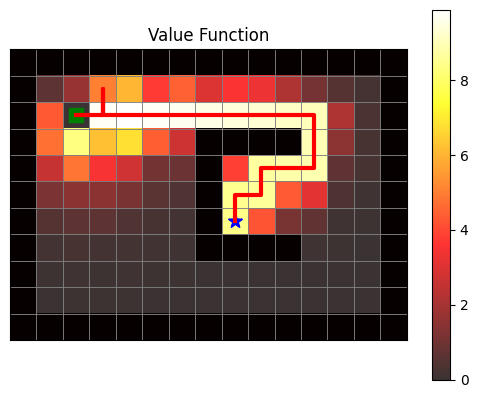

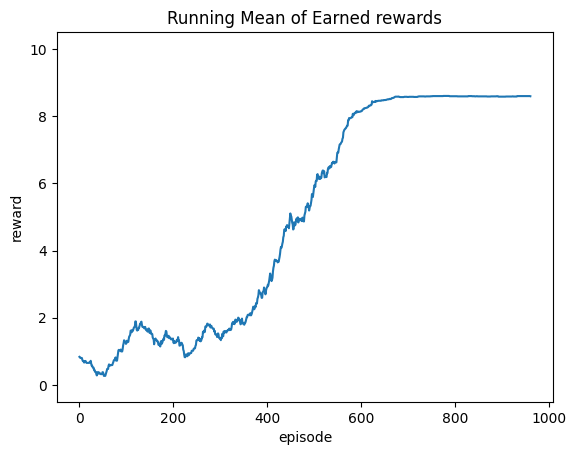

In [324]:
state_representation = np.eye(len(transitions))
M, V, earned_rewards, traj, _ = actor_critic(state_representation, n_steps=300, alpha=0.05, gamma=0.99, n_episodes=1000)

plot_maze(maze, start, goal)
plot_path(maze, int2state(traj[-1]))
plt.imshow(V.reshape(maze.shape), cmap='hot', alpha=0.8)
plt.colorbar()
plt.title("Value Function")
plt.show()

plt.plot(running_mean(earned_rewards, 40))
plt.ylim([-0.5, 10.5])
plt.xlabel("episode")
plt.ylabel("reward")
plt.title("Running Mean of Earned rewards")
plt.show()


# Part 2, now the same for an SR representation


100%|██████████| 1000/1000 [00:02<00:00, 339.24it/s]


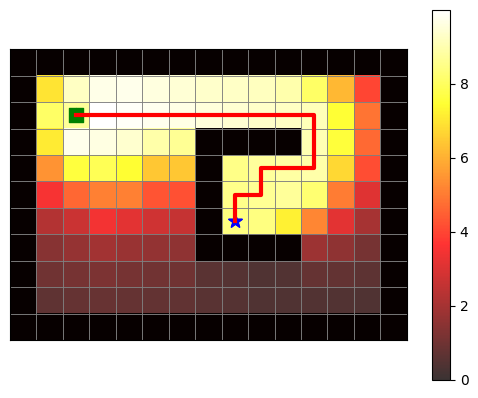

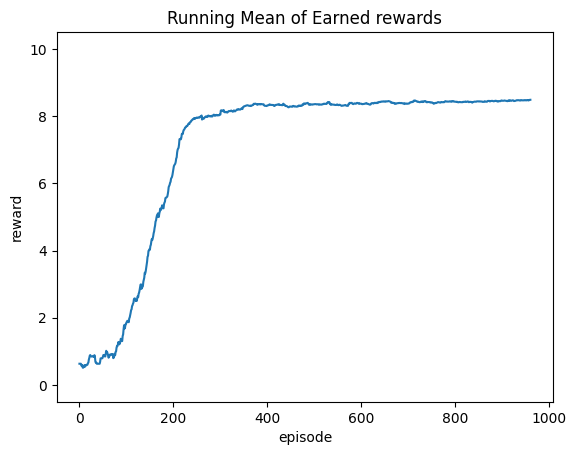

In [325]:
M, V, earned_rewards, traj, _ = actor_critic(analytical_state_repr, n_steps=300, alpha=0.05, gamma=0.99, n_episodes=1000)

plot_maze(maze, start, goal)
plot_path(maze, int2state(traj[-1]))
plt.imshow((analytical_state_repr @ V).reshape(maze.shape), cmap='hot', alpha=0.8)
plt.colorbar()
plt.show()

plt.plot(running_mean(earned_rewards, 40))
plt.ylim([-0.5, 10.5])
plt.xlabel("episode")
plt.ylabel("reward")
plt.title("Running Mean of Earned rewards")
plt.show()



# Part 3

In [326]:
def random_start():
    # define yourself a function to return a random (non-wall) starting state to pass into the actor_critic function

    mask = transitions.sum(axis=1)
    mask[mask == 0] = -np.inf
    p = softmax(mask)
    return np.random.choice(len(p), p=p)

100%|██████████| 1000/1000 [00:01<00:00, 598.63it/s]


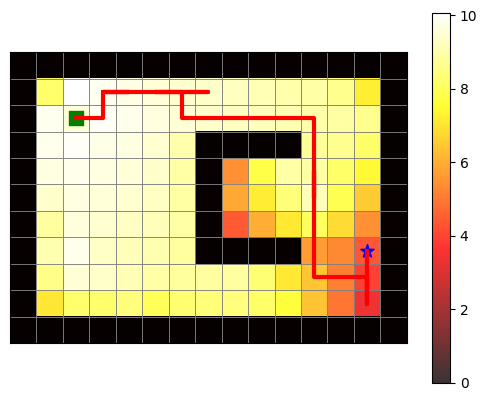

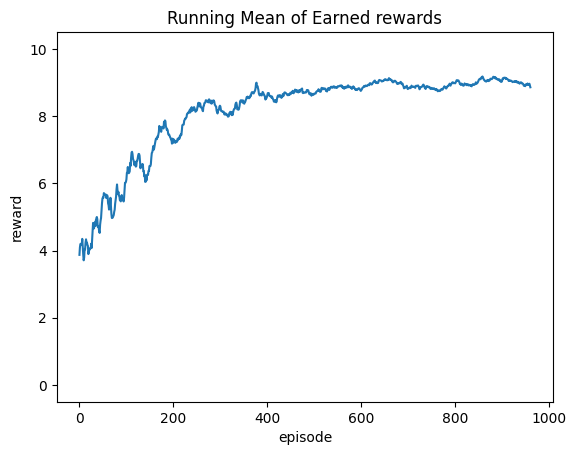

In [327]:
M, V, earned_rewards, traj, _ = actor_critic(
    analytical_state_repr,
    300,
    0.05,
    0.99, 
    1000,
    update_sr=False,
    start_func=random_start,
)
# plot state-value function
plot_maze(maze, None, goal)
plot_path(maze, int2state(traj[-1]))
plt.imshow((analytical_state_repr @ V).reshape(maze.shape), cmap='hot', alpha=0.8)
plt.colorbar()
plt.show()

plt.plot(running_mean(earned_rewards, 40))
plt.ylim([-0.5, 10.5])
plt.xlabel("episode")
plt.ylabel("reward")
plt.title("Running Mean of Earned rewards")
plt.show()

100%|██████████| 1000/1000 [00:01<00:00, 516.97it/s]


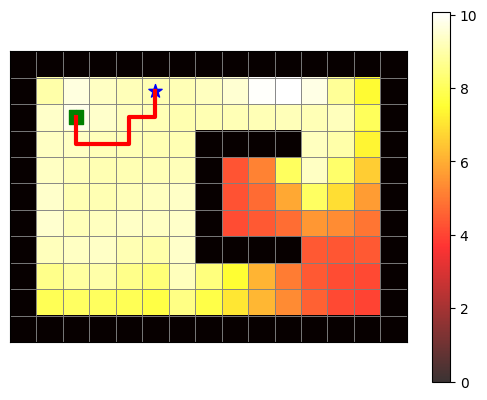

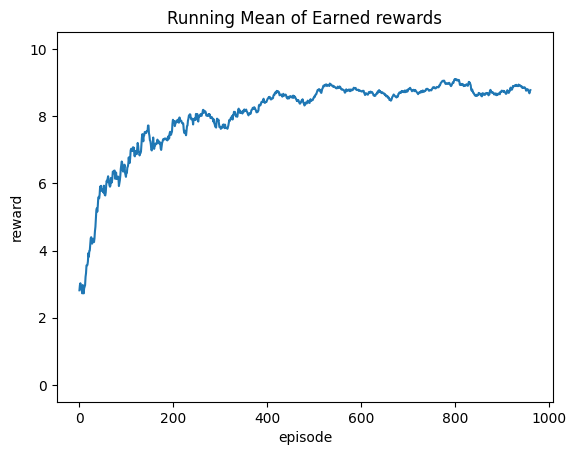

In [328]:
M, V, earned_rewards, traj, learned_state_repr = actor_critic(
    analytical_state_repr,
    300,
    0.05,
    0.99, 
    1000,
    update_sr=True,
    start_func=random_start,
)
# plot state-value function
plot_maze(maze, None, goal)
plot_path(maze, int2state(traj[-1]))
plt.imshow((learned_state_repr @ V).reshape(maze.shape), cmap='hot', alpha=0.8)
plt.colorbar()
plt.show()

plt.plot(running_mean(earned_rewards, 40))
plt.ylim([-0.5, 10.5])
plt.xlabel("episode")
plt.ylabel("reward")
plt.title("Running Mean of Earned rewards")
plt.show()

plot the SR of some states after this learning, also anything else you want

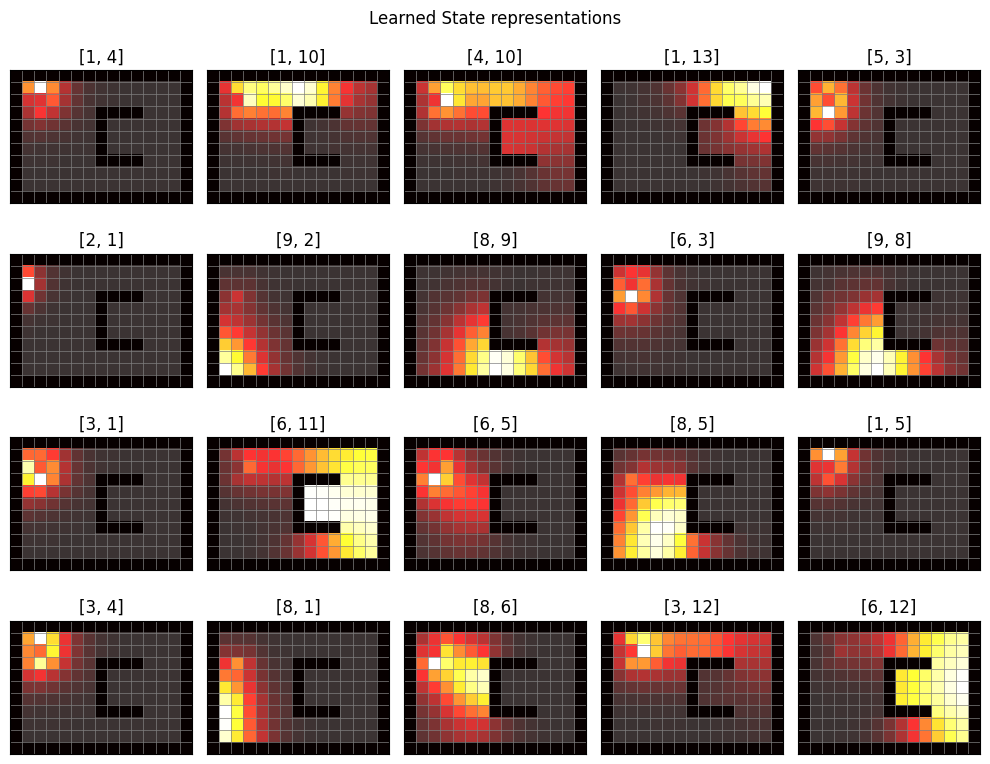

In [329]:
# plot the SR of some states after this learning, also anything else you want
fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(10, 8))

for ax in axs.flatten():
    # plot state-value function
    pos = random_start()
    corrds = int2state(pos)
    ax.set_title(corrds.tolist())
    plot_maze(maze, None, None, ax=ax)
    ax.imshow((learned_state_repr[pos]).reshape(maze.shape), cmap='hot', alpha=0.8)

fig.suptitle("Learned State representations")
fig.tight_layout()

# Part 4

In [330]:
stats = {"rewards": [[], []]}

goal = (6, 6)
goal_state = goal[0] * maze.shape[1] + goal[1]
for i in range(20):
    # run with random walk SR
    M_clamped, V_clamped, earned_rewards_clamped, traj_clamped, _ = actor_critic(
        analytical_state_repr,
        300,
        0.05,
        0.99,
        1000,
    )
    stats["rewards"][0].append(earned_rewards_clamped)

    # run with updated SR
    M_relearned, V_relearned, earned_rewards_relearned, traj_relearned, learned_state_repr_relearned = actor_critic(
        learned_state_repr,
        300,
        0.05,
        0.99,
        1000,
        update_sr=True,
    )
    stats["rewards"][1].append(earned_rewards_relearned)

100%|██████████| 1000/1000 [00:03<00:00, 329.33it/s]


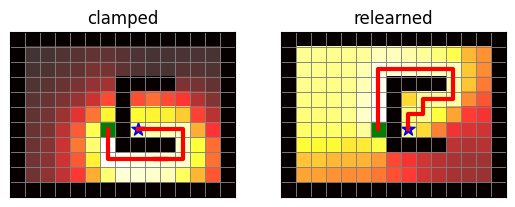

In [331]:
# plot state-value function
fig, ax = plt.subplots(ncols=2)
plot_maze(maze, None, goal, ax=ax[0])
plot_path(maze, int2state(traj_clamped[-1]), ax=ax[0])
ax[0].imshow((analytical_state_repr @ V_clamped).reshape(maze.shape), cmap='hot', alpha=0.8)
plot_maze(maze, None, goal, ax=ax[1])
plot_path(maze, int2state(traj_relearned[-1]), ax=ax[1])
ax[1].imshow((learned_state_repr_relearned @ V_relearned).reshape(maze.shape), cmap='hot', alpha=0.8)

ax[0].set_title("clamped")
ax[1].set_title("relearned")

plt.show()



plot the performance averages of the two types of learners


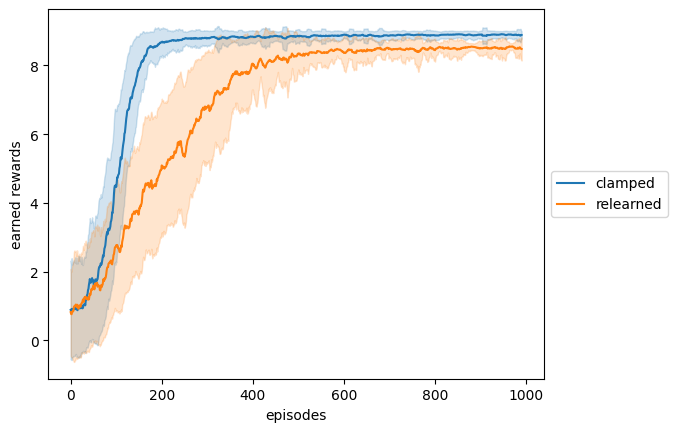

In [364]:
reward_stats = np.stack(stats["rewards"])

mean_base = reward_stats.mean(axis=1)
mean = np.stack(
    [
        running_mean(mean_base[0], 10),
        running_mean(mean_base[1], 10),
    ]
)

std_base = reward_stats.std(axis=1)
std = np.stack(
    [
        running_mean(std_base[0], 10),
        running_mean(std_base[1], 10),
    ]
)

plt.plot(mean[0], label="clamped")
plt.fill_between(
    np.arange(len(mean[0])),
    mean[0] - std[0],
    mean[0] + std[0],
    color=tab10(0),
    alpha=0.2,
)
plt.plot(mean[1], label="relearned")
plt.fill_between(
    np.arange(len(mean[1])),
    mean[1] - std[1],
    mean[1] + std[1],
    color=tab10(1),
    alpha=0.2,
)

plt.xlabel("episodes")
plt.ylabel("earned rewards")
plt.legend(loc="center left",bbox_to_anchor=(1,0.5))

# Part 5

In [356]:
# reset goal
goal = (1, 1)
goal_state = goal[0] * maze.shape[1] + goal[1]

# run some learners with different value weight w initializations
N_BOOT = 4
N_PARAMS = 5
N_EPISODES = 1000
v_inits = np.linspace(0, 40, N_PARAMS)
boot_stats = {"reward_one_hot": np.zeros((N_BOOT, N_PARAMS, N_EPISODES)), "reward_sr": np.zeros((N_BOOT, N_PARAMS, N_EPISODES))}

for v_init_idx, boot_idx in tqdm(product(range(N_PARAMS), range(N_BOOT))):
    M_one_hot, V_one_hot, earned_rewards_one_hot, traj_one_hot, _ = actor_critic(
        np.eye(len(transitions)),
        300,
        0.05,
        0.99,
        N_EPISODES,
        v_init=v_inits[v_init_idx],
        start_func=normal_start,
        quiet=True,
    )
    boot_stats["reward_one_hot"][boot_idx, v_init_idx] = earned_rewards_one_hot
    M_sr, V_sr, earned_rewards_sr, traj_sr, _ = actor_critic(
        analytical_state_repr,
        300,
        0.05,
        0.99,
        N_EPISODES,
        v_init=v_inits[v_init_idx],
        start_func=normal_start,
        quiet=True,
    )
    boot_stats["reward_sr"][boot_idx, v_init_idx] = earned_rewards_sr

20it [05:43, 17.19s/it]


Text(0.5, 1.0, 'Different value initializations')

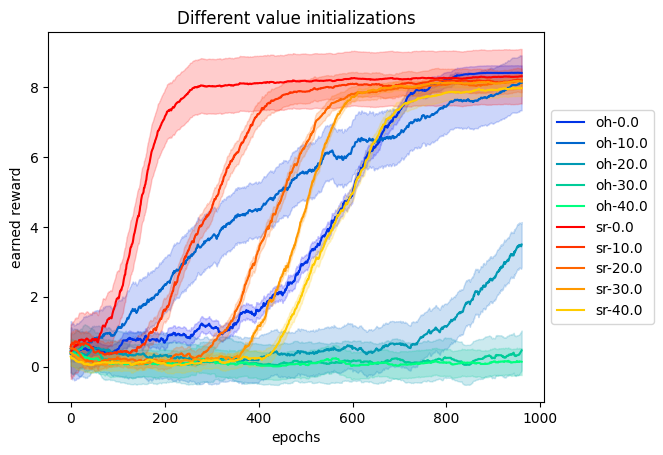

In [369]:
reward_one_hot = np.stack(boot_stats["reward_one_hot"])
reward_sr = np.stack(boot_stats["reward_sr"])


reward_one_hot = reward_one_hot.mean(axis=0)
reward_one_hot_std = reward_one_hot.std(axis=0)
reward_sr = reward_sr.mean(axis=0)
reward_sr_std = reward_sr.std(axis=0)

one_hot_cm = mpl.colormaps["winter"]
sr_cm = mpl.colormaps["autumn"]

for param_idx, param in enumerate(v_inits):
    plt.plot(
        running_mean(reward_one_hot[param_idx], 40),
        label=f"oh-{param}",
        color=one_hot_cm((param_idx + 1) / N_PARAMS),
    )
    plt.fill_between(
        np.arange(len(reward_one_hot[param_idx]) - 39),
        running_mean(reward_one_hot[param_idx] - reward_one_hot_std[param_idx], 40),
        running_mean(reward_one_hot[param_idx] + reward_one_hot_std[param_idx], 40),
        color=one_hot_cm(param_idx / N_PARAMS),
        alpha=0.2
    )

for param_idx, param in enumerate(v_inits):
    plt.plot(
        running_mean(reward_sr[param_idx], 40),
        label=f"sr-{param}",
        color=sr_cm((param_idx + 0) / N_PARAMS ),
    )
    plt.fill_between(
        np.arange(len(reward_sr[param_idx]) - 39),
        running_mean(reward_sr[param_idx] - reward_sr_std[param_idx], 40),
        running_mean(reward_sr[param_idx] + reward_sr_std[param_idx], 40),
        color=sr_cm(param_idx / N_PARAMS),
        alpha=0.2
    )
    

plt.legend(loc="center left",bbox_to_anchor=(1,0.5))
plt.xlabel("epochs")
plt.ylabel("earned reward")
plt.title("Different value initializations")
